In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
from cvxpy import *
from DTools2 import *
from matplotlib import gridspec
from matplotlib.patches import Rectangle
%matplotlib inline


# Data prep

Import the COMPAS dataset.

In [2]:
DATA_FOLDER = '../data/'

df = pd.read_csv(
    DATA_FOLDER + 'compas-scores-two-years.csv',
    index_col=0)

In [4]:
df.shape

(7214, 52)

However not all of the rows are useable for the first round of analysis.

**From the ProPublica notebook**: There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [5]:
df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
ix = df['days_b_screening_arrest'] <= 30
ix = (df['days_b_screening_arrest'] >= -30) & ix
ix = (df['is_recid'] != -1) & ix
ix = (df['c_charge_degree'] != "O") & ix
ix = (df['score_text'] != 'N/A') & ix
df = df.loc[ix,:]
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])-pd.to_datetime(df['c_jail_in'])).apply(lambda x: x.days)
list(df)

['age',
 'c_charge_degree',
 'race',
 'age_cat',
 'score_text',
 'sex',
 'priors_count',
 'days_b_screening_arrest',
 'decile_score',
 'is_recid',
 'two_year_recid',
 'c_jail_in',
 'c_jail_out',
 'length_of_stay']

Out of interest, plot distribution of COMPAS scores (matches the one in the ProPublica article).

(0.5, 10.5)

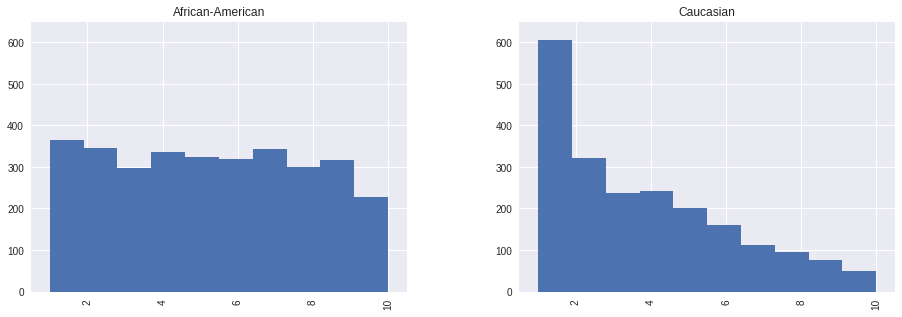

In [6]:
df2 = df.loc[df['race'].isin(['African-American','Caucasian']),['race','decile_score']]
ax = df2.hist(column='decile_score',by='race',figsize=(15,5),**{'normed':False})
ax[0].set_ylim([0,650])
ax[1].set_ylim([0,650])
ax[0].set_xlim([.5,10.5])
ax[1].set_xlim([.5,10.5])

Number of entries per decile score for each race.

In [7]:
df.groupby(['race','decile_score']).size().reset_index().pivot(index='decile_score',columns='race',values=0)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365.0,15.0,605.0,159.0,NaN,142.0
2,346.0,4.0,321.0,89.0,2.0,60.0
3,298.0,5.0,238.0,73.0,1.0,32.0
4,337.0,NaN,243.0,47.0,NaN,39.0
5,323.0,1.0,200.0,39.0,NaN,19.0
6,318.0,2.0,160.0,27.0,2.0,20.0
7,343.0,1.0,113.0,28.0,2.0,9.0
8,301.0,2.0,96.0,14.0,NaN,7.0
9,317.0,NaN,77.0,17.0,2.0,7.0


Drop Asian, Native American due to lack of samples

In [8]:
dfcut = df.loc[~df['race'].isin(['Native American','Hispanic','Asian','Other']),:]

Now we quantize the dataframe. In particular, we will quantize the priors, the length of stay and the compas score.

In [9]:
dfcutQ = dfcut[['sex','race','age_cat','c_charge_degree','score_text','priors_count','is_recid',
                'two_year_recid','length_of_stay']].copy()

# Quantize priors count between 0, 1-3, and >3
def quantizePrior(x):
    if x <=0:
        return '0'
    elif 1<=x<=3:
        return '1 to 3'
    else:
        return 'More than 3'

    
# Quantize length of stay
def quantizeLOS(x):
    if x<= 7:
        return '<week'
    if 8<x<=93:
        return '<3months'
    else:
        return '>3 months'
    
# Quantize length of stay
def adjustAge(x):
    if x == '25 - 45':
        return '25 to 45'
    else:
        return x

# Quantize score_text to MediumHigh
def quantizeScore(x):
    if (x == 'High')| (x == 'Medium'):
        return 'MediumHigh'
    else:
        return x

    
dfcutQ['priors_count'] = dfcutQ['priors_count'].apply(lambda x: quantizePrior(x))
dfcutQ['length_of_stay'] = dfcutQ['length_of_stay'].apply(lambda x: quantizeLOS(x))
dfcutQ['score_text'] = dfcutQ['score_text'].apply(lambda x: quantizeScore(x))
dfcutQ['age_cat'] = dfcutQ['age_cat'].apply(lambda x: adjustAge(x))



We'll be interested, for now, in gender, race, age, charge degree, priors count, and recidivism (the Y variable).

In [10]:
#features = ['sex','race','age_cat','c_charge_degree','priors_count','is_recid']
features = ['race','age_cat','c_charge_degree','priors_count','is_recid']

# Pass vallue to df
df = dfcutQ[features]

Next, we do a 80-20 split of the data. The random number generator seed is fixed, so this should generate consistent splits. We automatically rename output files accordingly. Pairs of train and test dataset are stored in `df_list`.

In [11]:
df.shape

(5278, 5)

In [9]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=888)  ### CHANGE SEED FOR DIFFERENT SPLITS!
df_list = []
for train_index,test_index in rs.split(df):
    df_list.append((df.iloc[train_index,:].copy(),df.iloc[test_index,:].copy()))
    

We'll be interested, for now, in gender, race, age, charge degree, priors count, and recidivism (the Y variable). We initialize the optimization object.

In [10]:
DT = DTools(df=df,features=features)

Set discriminatory features (`D_features`), binary response variable (`Y_features`) and decision features (`X_features`), and initialize the Discrimination Tools class).

In [11]:
#D_features = ['sex','race']
D_features = ['race']
Y_features = ['is_recid']
X_features = ['age_cat', 'c_charge_degree','priors_count']

DT.setFeatures(D=D_features,X=X_features,Y=Y_features)

Now we set the distortion metric. This function will receive the two dictionary of features X and Y corresponding to the new and old values, and return a distortion value. In this case the distortion function returns 1000 if education is lowered by any value, or increased by more than 1 year, or if age is increased or decreased by more than one decade. In returns a penalty of 1.0 if income is decreased. All other values are 0.

In [12]:
class Dclass():
# adjust education
    def adjustPrior(self,v):
        if v=='0':
            return 0
        elif v=='1 to 3':
            return 1
        else:
            return 2

    def adjustAge(self,a):
        if a == 'Less than 25':
            return 0
        elif a == '25 to 45':
            return 1
        else:
            return 2

    # distortion metric
    def getDistortion(self,vold,vnew):
        '''
        Distortion metric.

        Inputs:
        *vold : dictionary of the form {attr:value} with old values
        *vnew : dictionary of the form {attr:value} with new values

        Output
        *d : distortion value
        '''

        # value that will be returned for events that should not occur
        bad_val = 1e4


        # Adjust prior
        pOld = self.adjustPrior(vold['priors_count'])
        pNew = self.adjustPrior(vnew['priors_count'])

        # Priors cannot be increased, or lowered by more than 1 category. A change has a unit penalty
        if (pNew>pOld)| (pNew<pOld-1):
            return bad_val

        # adjust age
        aOld = self.adjustAge(vold['age_cat'])
        aNew = self.adjustAge(vnew['age_cat'])

        # Age cannot be increased or decreased in more than one category
        if np.abs(aOld-aNew)>1.0:
            return bad_val
        
        # Recidivism should not be increased
        if vold['is_recid'] < vnew['is_recid']:
            return bad_val
        
        cum_sum = 0.0
        
        
        if np.abs(aOld-aNew)>0:
#             cum_sum+=1
#             cum_sum = cum_sum**2
           cum_sum = cum_sum+1
           
        # Penalty of 1 if priors is decreased or increased
        if np.abs(pNew-pOld)>0:
#             cum_sum+=1
#             cum_sum = cum_sum**2
            cum_sum = cum_sum+1
           

           #cum_sum = cum_sum**2
        if vold['is_recid'] > vnew['is_recid']:
#             cum_sum+=1
#             cum_sum = cum_sum**2
            cum_sum = cum_sum+1
           
       

       # final penalty of 2 for changing misdemeanor to felony and vice-verse
        if vold['c_charge_degree'] != vnew['c_charge_degree']:
#             cum_sum+=2
#             cum_sum = cum_sum**2
           cum_sum = cum_sum+4
            
        return cum_sum
        

We set the excess distortion constraints (`c1` and `c2`) and set the distortion values. For now, we are solving the problem (to view the equation correctly you have to run the last markdown cell of this notebook with the latex preamble)

\begin{align}
	\min_{p_{\Xh,\Yh|X,Y,D}}& \sum_{x,y} \left| p_{X,Y}(x,y)- p_{\Xh,\Yh}(x,y)\right| \\
	\sto~~&  1-\epsilon\leq \frac{p_{\Yh|D}(y|d_1)}{p_{\Yh|D}(y|d_2)} \leq 1+\epsilon, \forall y\in \calY, d_1,d_2\in \calD\\
	&\mathbb{E}\left( d(x,y,\Xh,\Yh) \mid X=x,Y=y,D=d\right) \leq \delta_D~\forall~(x,y)\in \calX\times \calY,\\
	&p_{\Xh,\Yh|X,Y,D} \mbox{ is a valid distribution.}
\end{align}

We set `c1=.99`, `c2 = 1.99`, and `c3=2.99`.

In [13]:
# c1 = .99 # value of (delta1,c1): to keep.
# c2 = 1.99  # value of (delta2,c2): value that should no happen
# c3 = 2.99 # penalty things that should not happen
# clist = [c1,c2, c3]
Dclass = Dclass()

DT.setDistortion(Dclass)

Next, we generate the plot for choosing the operation points


  0%|          | 0/20 [00:00<?, ?it/s]/home/bhanu/anaconda3/envs/python2/lib/python2.7/site-packages/cvxpy/problems/solvers/cbc_intf.py:140: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  x = model.addVariable('x', n)
/home/bhanu/anaconda3/envs/python2/lib/python2.7/site-packages/cylp/py/modeling/CyLPModel.py:193: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (other == None):
/home/bhanu/anaconda3/envs/python2/lib/python2.7/site-packages/cylp/py/modeling/CyLPModel.py:516: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.lower == None:
/home/bhanu/anaconda3/envs/python2/lib/python2.7/site-packages/cvxpy/problems/solvers/cbc_intf.py:150: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  model += A[0:dims[s.EQ_DIM], :] * x == b[0:dims[s.EQ_DIM]]
100%|██████████| 20/20 [

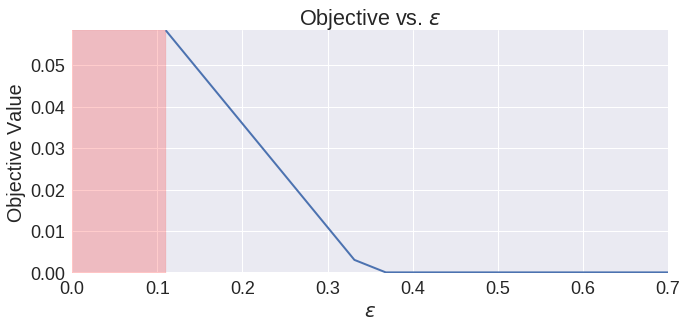

In [14]:

npoints = 20
epsilonV = np.linspace(0,.7,npoints)
y = np.zeros(npoints)
z = np.zeros(npoints)
#epsilon = .05
meanV = np.linspace(3.45,3.46,npoints)
#dlist = [0.15,0.075,0]
# create same distortion for all categories

# number of categories
values = list(itertools.product(*DT.D_values))


for i in tqdm(range(npoints)):
    #mean = meanV[i]
    epsilon = epsilonV[i]
    dlist = []
    for v in values:
        if 'African-American' in v:
            #mean_value = .4 #original in ICML submission - mean_value = .25
            mean_value=.2 #used for data 3
        else:
            #mean_value = .3 #original in ICML submission - mean_value = .25
            mean_value=.1 # used for data 3
        dlist.append((v,mean_value))
    
    DT.optimize(epsilon=epsilon,dlist = dlist,verbose=False,cost='TV',solver='CBC')
    y[i] = DT.optimum
    
y2 = np.array([max(t,0) for t in y])

sns.set(font_scale=1.8,font='sans-serif')
plt.figure(figsize = (10,5))
ax = plt.plot(epsilonV,y2,'-',linewidth=2)
plt.ylabel("Objective Value")
plt.xlabel("$\epsilon$")
plt.title("Objective vs. $\epsilon$")# for\n$\delta_1 =$"+str(dlist[0])+", $\delta_2=$"+str(dlist[1])+" and $\delta_3=$"+str(dlist[2]))
infeasible = np.where(y==np.inf)[0]
if len(infeasible) == 0:
    infeasible = [-1]
plt.axvspan(0, epsilonV[infeasible[-1]+1], color='red', alpha=0.2)
plt.xlim([epsilonV.min(),epsilonV.max()])
plt.ylim([-0.0001,y2[y2<np.inf].max()+0.0001])

#plt.text(0.05, 0.005, r'Infeasible', fontsize=20)
plt.tight_layout()
#plt.savefig('./plots/tradeoff3.pdf')

Great, let's choose an operating point for the values of distortion above. We select $\epsilon=.2$, and a mean distortion value that is higher for African-Americans (due to inherent biases), and smaller for other groups. 

In [15]:
#epsilon = .1
epsilon=.2
dlist = []
for v in values:
    if 'African-American' in v:
        mean_value = .4 #original in ICML submission - mean_value = .25
        #mean_value=.22
    else:
        mean_value = .3 #original in ICML submission - mean_value = .25
        #mean_value=.22
    dlist.append((v,mean_value))

We'll print the marginals out in this case just to make sure it is operating as intended.

In [16]:
# Optimize
DT.optimize(epsilon=epsilon,dlist = dlist,verbose=False,cost='TV',solver='CBC')

# Compute marginals
DT.computeMarginals()

# This is what pyhgd will look like for y=1
v = DT.dfPyhgD[0].values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=DT.dfPyhgD[0].index,columns=DT.dfPyhgD[0].index )
print ratio_df

print 'Discrimination (y=1)'
ratio_df_arr=np.asarray(np.abs(1-ratio_df))
discrim=np.amax(ratio_df_arr)
discrim

# This is what pyhgd will look like for y=0
v = 1-DT.dfPyhgD[0].values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=DT.dfPyhgD[0].index,columns=DT.dfPyhgD[0].index )
print ratio_df

print 'Discrimination (y=0)'
ratio_df_arr=np.asarray(np.abs(1-ratio_df))
discrim=np.amax(ratio_df_arr)
discrim


race              African-American  Caucasian
race                                         
African-American          1.000000   0.755589
Caucasian                 1.323471   1.000000
Discrimination (y=1)
race              African-American  Caucasian
race                                         
African-American          1.000000   1.343691
Caucasian                 0.744219   1.000000
Discrimination (y=0)


0.34369127258482246

This is an auxiliary function for helping in randomizing the dataset. It receives a dataset and a mapping, and randomizes accordingly. I'm fixing the value of the seed for numpy -- you may want to change this in order to produce fresh datasets.

In [17]:
######### CHANGE SEED HERE ###########
seed = sum([ord(b) for b in 'Bhanu'])
np.random.seed(seed = seed)
####################################

def randomize(df, dfMap,features=[]):
    df2 = df.copy()
    print('Randomizing...')
    for idx in tqdm(df2.index):
        rowTest = df2.loc[idx,:]
        vals = rowTest[features]
        draw = dfMap.loc[tuple(vals.tolist())]
        #randomly select value

        mapVal = np.random.choice(range(len(draw)),p=draw.tolist())
        draw.index[mapVal]
        df2.loc[idx,draw.index.names] = draw.index[mapVal]
        
    return df2


## Main loop

This is where the brute of the work will be done. May take a while to run, and will print randomization progress.

In [18]:
result_folder = '../experiment_data3/'
split_num = 0

# iterate over pairs
for (df_train,df_test) in df_list[1:2]:
    file_name = str(split_num)
    
    print('-----------------')
    print('Current split: '+file_name)

    # initialize a new DT object
    DT = DTools(df=df_train,features=features)

    # Set features
    DT.setFeatures(D=D_features,X=X_features,Y=Y_features)

    # Set Distortion
    DT.setDistortion(Dclass)

    # solve optimization for previous parameters -- This uses and older implementation, based on the FATML submission.
    DT.optimize(epsilon=epsilon,dlist = dlist,verbose=False,cost='TV',solver='CBC')

    DT.computeMarginals()

    # randomized mapping for training
    # this is the dataframe with the randomization for the train set
    dfPtrain = DT.dfP.applymap(lambda x : 0 if x<1e-8 else x)
    dfPtrain = dfPtrain.divide(dfPtrain.sum(axis=1),axis=0)

    # randomized mapping for testing (Beware of ugly code)
    d1 = DT.dfFull.reset_index().groupby(D_features+X_features).sum()
    d2 = d1.transpose().reset_index().groupby(X_features).sum()
    dTest = d2.transpose()
    dTest = dTest.drop(Y_features,1)
    dTest = dTest.applymap(lambda x: x if x>1e-8 else 0)
    dTest = dTest/dTest.sum()

    # this is the dataframe with the randomization for the test set
    dfPtest = dTest.divide(dTest.sum(axis=1),axis=0)

    # Randomize train data
    print('Randomizing training set...')
    df_train_new = randomize(df_train,dfPtrain,features = D_features+X_features+Y_features)

    # Randomize test data
    print('Randomizing test set...')
    df_test_new = randomize(df_test,dfPtest,features = D_features+X_features)

    # Save train files
    df_train.to_csv(result_folder+'train_'+file_name+'.csv')
    df_train_new.to_csv(result_folder+'train_new_'+file_name+'.csv')

    # Save test files
    df_test.to_csv(result_folder+'test_'+file_name+'.csv')
    df_test_new.to_csv(result_folder+'test_new_'+file_name+'.csv')
    
    # increment split number
    split_num+=1

-----------------
Current split: 0


/home/bhanu/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/core/base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)
  1%|          | 25/4222 [00:00<00:17, 242.82it/s]

Randomizing training set...
Randomizing...


  5%|▍         | 49/1056 [00:00<00:02, 482.78it/s]

Randomizing test set...
Randomizing...


100%|██████████| 1056/1056 [00:02<00:00, 457.10it/s]


In [19]:
from sklearn.ensemble import RandomForestClassifier
print '----------------------------------------------------------------'
print 'RandForrest on perturbed data:'

# performance on perturbed train data
rf = RandomForestClassifier()
dft = pd.get_dummies(df_train_new[D_features+X_features])
rf.fit(dft,df_train_new[Y_features])
print 'Train performance (pert. dataset): '
print rf.score(dft,df_train_new[Y_features])

#dft = pd.get_dummies(df_test_new[D_features+X_features])
#print 'Test performance (pert. dataset): '
#print rf.score(dft,df_test_new[Y_features])
#print '---------------'

# performance on perturbed train data compared to original train data
#rf = RandomForestClassifier()
#dft = pd.get_dummies(df_train_new[D_features+X_features])
#rf.fit(dft,df_train_new[Y_features])
dft = pd.get_dummies(df_test_new[D_features+X_features])
print 'Perturbed test performance when scored on original test y variable: '
print rf.score(dft,df_test[Y_features])

dft = pd.get_dummies(df_test_new[D_features+X_features])
# save performance
df_test_pred = df_test_new
df_test_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print 'Discrimination metric:'
mean = df_test_pred.groupby('race')['pred'].mean()
v = mean.values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
ratio_df_arr=np.asarray(np.abs(1-ratio_df))
discrim=np.amax(ratio_df_arr)
discrim


----------------------------------------------------------------
RandForrest on perturbed data:
Train performance (pert. dataset): 
0.671482709616
Perturbed test performance when scored on original test y variable: 
0.607954545455
Discrimination metric:


/home/bhanu/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.48052210935440565

## Latex preamble cell and importing packages
$$\newcommand{\SNR}{\mbox{SNR}}$$
$$\newcommand{\dB}{\mbox{dB}}$$
$$\newcommand{\emu}{\colonsim}$$

$$\newcommand{\Fq}{\mathbb{F}_{q}}$$
$$\newcommand{\PR}{\mbox{Pr}}$$
$$\newcommand{\Lh}{\hat{l}}$$
$$\newcommand{\calX}{\mathcal{X}}$$
$$\newcommand{\calA}{\mathcal{A}}$$
$$\newcommand{\calB}{\mathcal{B}}$$
$$\newcommand{\calD}{\mathcal{D}}$$
$$\newcommand{\calK}{\mathcal{K}}$$
$$\newcommand{\calM}{\mathcal{M}}$$
$$\newcommand{\calY}{\mathcal{Y}}$$
$$\newcommand{\calT}{\mathcal{T}}$$
$$\newcommand{\calZ}{\mathcal{Z}}$$
$$\newcommand{\calJ}{\mathcal{J}}$$
$$\newcommand{\calC}{\mathcal{C}}$$
$$\newcommand{\calS}{\mathcal{S}}$$
$$\newcommand{\calU}{\mathcal{U}}$$
$$\newcommand{\calV}{\mathcal{V}}$$
$$\newcommand{\calI}{\mathcal{I}}$$
$$\newcommand{\calF}{\mathcal{F}}$$
$$\newcommand{\calG}{\mathcal{G}}$$
$$\newcommand{\calH}{\mathcal{H}}$$
$$\newcommand{\calP}{\mathcal{P}}$$
$$\newcommand{\calL}{\mathcal{L}}$$
$$\newcommand{\Xk}{\mathcal{X}^k}$$
$$\newcommand{\Xn}{\mathcal{X}^n}$$
$$\newcommand{\floor}[1]{\lfloor #1 \rfloor}$$
$$\newcommand{\ceil}[1]{\lceil #1 \rceil}$$
$$\newcommand{\mean}{\mathbb{E}}$$
$$\newcommand{\bc}{\mathbf{c}}$$
$$\newcommand{\bs}{\mathbf{s}}$$
$$\newcommand{\bA}{\mathbf{A}}$$
$$\newcommand{\bH}{\mathbf{H}}$$
$$\newcommand{\bG}{\mathbf{G}}$$
$$\newcommand{\bD}{\mathbf{D}}$$
$$\newcommand{\bC}{\mathbf{C}}$$
$$\newcommand{\bF}{\mathbf{F}}$$
$$\newcommand{\bB}{\mathbf{B}}$$
$$\newcommand{\bI}{\mathbf{I}}$$
$$\newcommand{\bR}{\mathbf{R}}$$
$$\newcommand{\bW}{\mathbf{W}}$$
$$\newcommand{\bY}{\mathbf{Y}}$$
$$\newcommand{\bZ}{\mathbf{Z}}$$
$$\newcommand{\bx}{\mathbf{x}}$$
$$\newcommand{\rank}{\mbox{rank}}$$
$$\newcommand{\bz}{\mathbf{z}}$$
$$\newcommand{\bX}{\mathbf{X}}$$
$$\newcommand{\br}{\mathbf{r}}$$
$$\newcommand{\bbz}{\mathbf{z}}$$
$$\newcommand{\binstr}{\{0,1\}} $$
$$\newcommand{\supp}{\mbox{supp}}$$
$$\renewcommand{\tilde}{\widetilde}$$
$$\newcommand{\Enc}{\mathsf{Enc}}$$
$$\newcommand{\Dec}{\mathsf{Dec}}$$
$$\newcommand{\Adv}{\mathsf{Adv}}$$
$$\newcommand{\chis}{\chi^2}$$
$$\newcommand{\Xh}{\hat{X}}$$
$$\newcommand{\Dh}{\hat{D}}$$
$$\newcommand{\Yh}{\hat{Y}}$$
$$\newcommand{\Zh}{\hat{Z}}$$
$$\DeclareMathOperator*{\argmin}{\arg\!\min}$$
$$\DeclareMathOperator*{\argmax}{\arg\!\max}$$
$$\newcommand{\brk}[1]{\langle #1 \rangle}$$
$$\newcommand{\Reals}{\mathbb{R}}$$
$$\newcommand{\normQ}[1]{\| #1 \|_Q}$$
$$\newcommand{\normF}[1]{\| #1 \|_F}$$
$$\newcommand{\normX}[2]{\| #1 \|_{#2}}$$
$$\newcommand{\normEuc}[1]{\| #1 \|_2}$$
$$\newcommand{\ox}{\bar{x}}$$
$$\newcommand{\ones}{\mathbf{1}}$$
$$\newcommand{\inertia}{\mathcal{I}}$$
$$\newcommand{\defined}{\triangleq}$$
$$\newcommand{\Tr}[1]{\mathrm{ tr}\left(#1 \right)}$$
$$\newcommand{\diag}[1]{\mathrm{diag}\left( #1 \right)}$$
$$\newcommand{\pxy}{p_{X,Y}}$$
$$\newcommand{\px}{p_X}$$
$$\newcommand{\py}{p_Y}$$
$$\newcommand{\pxp}{p_{X'}}$$
$$\newcommand{\pxgy}{p_{X|Y}}$$
$$\newcommand{\pygx}{p_{Y|X}}$$
$$\newcommand{\pbgx}{p_{B|X}}$$
$$\newcommand{\Ppygx}[1]{\mathbf{p}_{Y|X={#1}}}$$
$$\newcommand{\pxhgx}{p_{\Xh|X}}$$
$$\newcommand{\qx}{q_X}$$
$$\newcommand{\rx}{r_X}$$
$$\newcommand{\ExpVal}[2]{\mathbb{E}\left[ #2 \right]}$$
$$\newcommand{\Mopt}{M_{\mathrm{ML}}}$$
$$\newcommand{\tZ}{\tilde{Z}}$$
$$\newcommand{\tU}{\tilde{U}}$$
$$\newcommand{\tV}{\tilde{V}}$$
$$\newcommand{\tsigma}{\tilde{\sigma}}$$
$$\newcommand{\Pxy}{\mathbf{P}_{X,Y}}$$
$$\newcommand{\Pxnyn}{P_{X^n,Y^n}}$$
$$\newcommand{\Pxyp}{P_{X',Y'}}$$
$$\newcommand{\Pygx}{\mathbf{P}_{Y|X}}$$
$$\newcommand{\Pxxp}{\bP_{X,\Xh}}$$
$$\newcommand{\Pxhgx}{P_{\hat{X}|X}}$$
$$\newcommand{\Px}{\mathbf{p}_X}$$
$$\newcommand{\Qx}{\mathbf{q}_X}$$
$$\newcommand{\Rx}{\mathbf{r}_X}$$
$$\newcommand{\Pxp}{\mathbf{p}_{\Xh}}$$
$$\newcommand{\Py}{\mathbf{p}_Y}$$
$$\newcommand{\At}{\tilde{\mathbf{A}}}$$
$$\newcommand{\Bt}{\tilde{\mathbf{B}}}$$
$$\newcommand{\Ut}{\tilde{\mathbf{U}}}$$
$$\newcommand{\Vt}{\mathbf{\tilde{V}}}$$
$$\newcommand{\Yt}{\tilde{Y}}$$
$$\newcommand{\Zt}{\tilde{Z}}$$
$$\newcommand{\lambdat}{\tilde{\lambda}}$$
$$\newcommand{\Sigmat}{\tilde{\mathbf{\Sigma}}}$$
$$\newcommand{\by}{\mathbf{y}}$$
$$\newcommand{\Lb}{L}$$
$$\newcommand{\blambda}{\pmb{\lambda}}$$
$$\newcommand{\blambdat}{\tilde{\pmb{\lambda}}}$$
$$\newcommand{\bLambda}{\pmb{\Lambda}}$$
$$\newcommand{\Emat}{\mathbf{F}}$$
$$\newcommand{\bu}{\mathbf{u}}$$
$$\newcommand{\bv}{\mathbf{v}}$$
$$\newcommand{\ba}{\mathbf{a}}$$
$$\newcommand{\bb}{\mathbf{b}}$$
$$\newcommand{\btu}{\tilde{\mathbf{u}}}$$
$$\newcommand{\btv}{\tilde{\mathbf{v}}}$$
$$\newcommand{\tu}{\tilde{u}}$$
$$\newcommand{\tv}{\tilde{v}}$$
$$\newcommand{\olU}{\overline{\mathbf{U}}}$$
$$\newcommand{\deriv}[2]{\frac{\delta #1}{\delta #2}}$$
$$\newcommand{\sto}{\mbox{s.t.}}$$
$$\newcommand{\KFnorm}[2]{\| #1 \|_{#2}}$$
$$\newcommand{\Imeas}{J}$$
$$\newcommand{\bigO}{O}$$
$$\newcommand{\ttheta}{\tilde{\theta}}$$
$$\newcommand{\Var}[2]{\mathrm{Var}_{#1}#2 }$$
$$\newcommand{\whf}{\widehat{f}}$$
$$\newcommand{\whg}{\widehat{g}}$$
$$\newcommand{\ft}{\tilde{f}}$$
$$%\newcommand{\pbgx}{p_{B|X^n}}$$
$$\newcommand{\pbgy}{p_{B|Y^n}}$$
$$\newcommand{\whh}{\widehat{h}}$$
$$\newcommand{\EE}[1]{\ExpVal{}{#1}}$$
$$\newcommand{\whB}{\widehat{B}}$$
$$\newcommand{\wbeta}{\widehat{\beta}}$$
$$\newcommand{\xb}{\mathbf{x}}$$
$$\newcommand{\yb}{\mathbf{y}}$$
$$\newcommand{\fb}{\mathbf{f}}$$
$$\newcommand{\gb}{\mathbf{g}}$$
$$\newcommand{\bP}{\mathbf{P}}$$
$$\newcommand{\eye}{\mathbf{I}}$$
$$\newcommand{\bQ}{\mathbf{Q}}$$
$$\newcommand{\bU}{\mathbf{U}}$$
$$\newcommand{\bSigma}{\mathbf{\Sigma}}$$
$$\newcommand{\bsigma}{\boldsymbol\sigma}$$
$$\newcommand{\bV}{\mathbf{V}}$$
$$\newcommand{\bT}{\mathbf{T}}$$
$$\newcommand{\bbH}{\mathbf{H}}$$
$$\newcommand{\brho}{\boldsymbol{\rho}}$$
$$\newcommand{\suchthat}{\,\mid\,}$$
$$\newcommand{\indicator}{\mathds{1}}$$
$$\newcommand{\mmse}{\mathsf{mmse}}$$
$$\newcommand{\error}{\mathsf{e}}$$
$$\newcommand{\calN}{\mathcal{N}}$$
$$\newcommand{\cwd}{\{1,\dots,2^{nR} \}}$$
$$\newcommand{\Ps}{\mathbf{p}_S}$$
$$\newcommand{\bw}{\mathbf{w}}$$
$$\newcommand{\TV}{\mathsf{TV}}$$
$$\newcommand{\lse}{\mathsf{lmmse}}$$
$$\newcommand{\dks}{d_{\mathrm{KS}}}$$
$$\newcommand{\Xt}{\widetilde{X}}$$
$$\newcommand{\xh}{\hat{x}}$$
$$\newcommand{\vs}{v^*(p_{S,X})}$$
$$\newcommand{\dps}{\delta(p_{S,X})}$$
$$\newcommand{\bp}{\mathbf{p}}$$
$$\newcommand{\bq}{\mathbf{q}}$$
$$\newcommand{\simplex}{\Delta}$$
$$\newcommand\independent{\protect\mathpalette{\protect\independenT}{\perp}}$$
$$\def\independenT#1#2{\mathrel{\rlap{$#1#2$}\mkern2mu{#1#2}}}$$
$$\newcommand{\KC}{\calJ}$$
$$\newcommand{\Fsym}{\calF_{\mathrm{sym}}}$$
$$\newcommand{\bg}{\mathbf{g}}$$
$$\newcommand{\Dx}{\mathbf{D}_X}$$
$$\newcommand{\Dy}{\mathbf{D}_Y}$$

End load.